In [3]:
from pyexpat import features
%load_ext watermark
%watermark -p torch,lightning,torchmetrics

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
torch       : 2.2.2
lightning   : 2.5.2
torchmetrics: 1.7.4



# Load model

In [4]:
import lightning as L
import torch
from shared_utilities import LightningModel,PyTorchMLP,MNISTDataModule

In [6]:
pytroch_model = PyTorchMLP(num_features=784, num_classes=10)
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path='model.ckpt',model=pytroch_model)

In [7]:
dm = MNISTDataModule()
dm.setup(stage='test')

# Predict on new Data

In [8]:
import torchmetrics

test_loader = dm.test_dataloader()
acc = torchmetrics.Accuracy(task='multiclass',num_classes=10)

In [9]:
for batch in test_loader:
    features, class_labels = batch

    with torch.inference_mode():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    acc(predicted_labels, class_labels)

predicted_labels[:5]

tensor([1, 2, 3, 4, 5])

In [10]:
test_accuracy = acc.compute()
print(f"Test Accuracy: {test_accuracy*100:.2f}")

Test Accuracy: 97.10


# inspectinv failure cases which did not work

In [11]:
from shared_plotting import show_failures

In [12]:
class_dict = {
    0:'digit 0',
    1:'digit 1',
    2:'digit 2',
    3:'digit 3',
    4:'digit 4',
    5:'digit 5',
    6:'digit 6',
    7:'digit 7',
    8:'digit 8',
    9:'digit 9'
}

(<Figure size 640x480 with 15 Axes>,
 array([[<Axes: title={'center': 'P: digit 6\nT: digit 5'}>,
         <Axes: title={'center': 'P: digit 4\nT: digit 2'}>,
         <Axes: title={'center': 'P: digit 8\nT: digit 9'}>,
         <Axes: title={'center': 'P: digit 6\nT: digit 4'}>,
         <Axes: title={'center': 'P: digit 0\nT: digit 6'}>],
        [<Axes: title={'center': 'P: digit 7\nT: digit 2'}>,
         <Axes: title={'center': 'P: digit 3\nT: digit 5'}>,
         <Axes: title={'center': 'P: digit 7\nT: digit 3'}>,
         <Axes: title={'center': 'P: digit 0\nT: digit 6'}>,
         <Axes: title={'center': 'P: digit 8\nT: digit 5'}>],
        [<Axes: title={'center': 'P: digit 0\nT: digit 8'}>,
         <Axes: title={'center': 'P: digit 1\nT: digit 7'}>,
         <Axes: title={'center': 'P: digit 2\nT: digit 3'}>,
         <Axes: title={'center': 'P: digit 2\nT: digit 8'}>,
         <Axes: title={'center': 'P: digit 2\nT: digit 8'}>]], dtype=object))

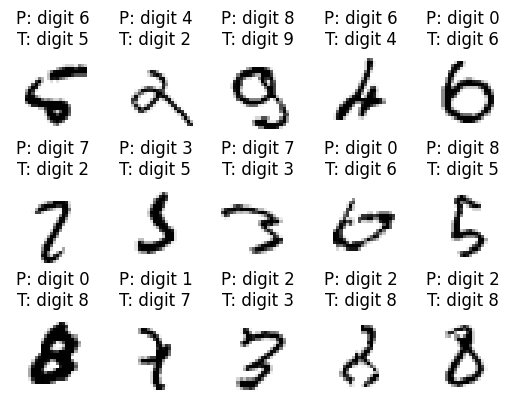

In [13]:
show_failures(
    lightning_model,
    data_loader=test_loader,
    class_dict=class_dict
)

In [14]:
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix



In [21]:
cmat = ConfusionMatrix(num_classes=len(class_dict), task='multiclass')

for x,y in test_loader:

    with torch.inference_mode():
        pred = lightning_model(x)
    cmat(pred,y)


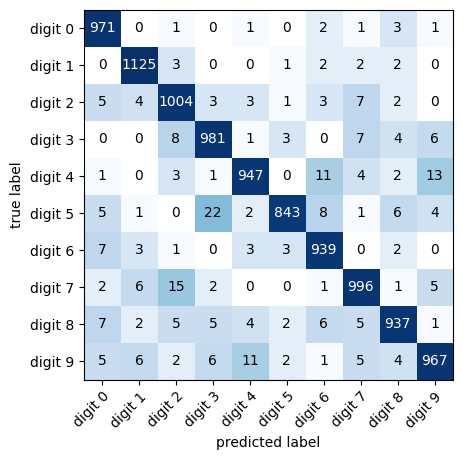

In [22]:
cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(conf_mat=cmat,
                                class_names=class_dict.values(),
                                norm_colormap=matplotlib.colors.LogNorm()
                                )